## Investment Assignment

### Objective

You work for Spark Funds, an asset management company. Spark Funds wants to make investments in a few companies. The CEO of Spark Funds wants to understand the global trends in investments so that she can take the investment decisions effectively.

The objective is to identify the best sectors, countries, and a suitable investment type for making investments. The overall strategy is to invest where others are investing, implying that the 'best' sectors and countries are the ones 'where most investors are investing'.

### Constraints

Spark Funds has two minor constraints for investments:

1. It wants to invest between 5 to 15 million USD per round of investment

2. It wants to invest only in English-speaking countries because of the ease of communication with the companies it would invest in

For your analysis, consider a country to be English speaking only if English is one of the official languages in that country

### Data Analysis Suggested

<b>Investment type analysis:</b> Comparing the typical investment amounts in the venture, seed, angel, private equity etc. so that Spark Funds can choose the type that is best suited for their strategy.
<br><b>Country analysis:</b> Identifying the countries which have been the most heavily invested in the past. These will be Spark Funds’ favourites as well.
<br><b>Sector analysis:</b> Understanding the distribution of investments across the eight main sectors. (Note that we are interested in the eight 'main sectors' provided in the mapping file. The two files — companies and rounds2 — have numerous sub-sector names; hence, you will need to map each sub-sector to its main sector.)

In [504]:
!ls

 Dataset		       INVEST.pptx
 Investment_Assignment.ipynb  'Spark Funds Presentation.pptx'
 Investments.xlsx	      'Trainer Materials'


### Dataset

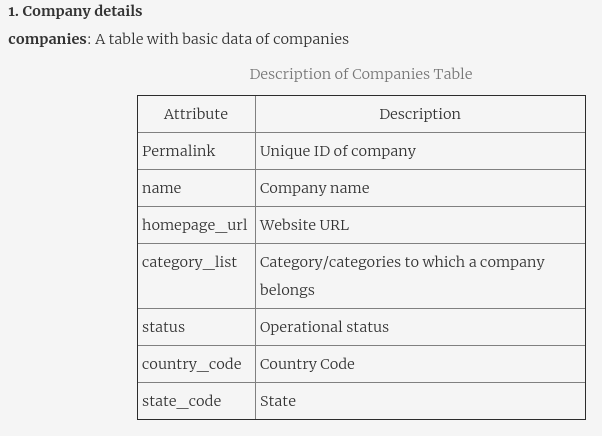

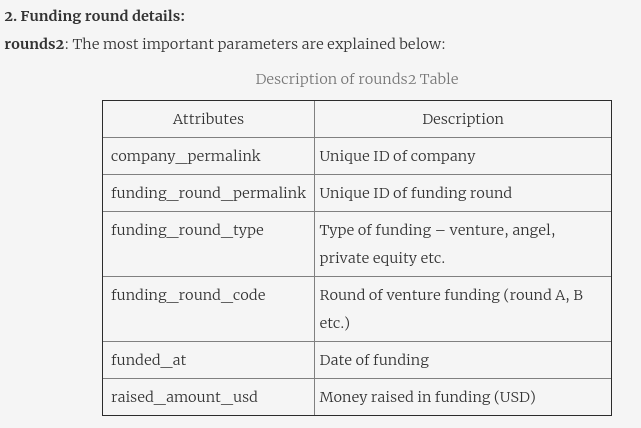

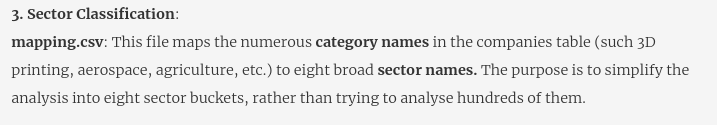

### Importing necessary libraries

In [505]:
import numpy as np
import pandas as pd
import chardet
import seaborn as sns
import matplotlib.pyplot as plt

### Know the encoding of each file

In [506]:
with open("Dataset/companies.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(50000))

print(result)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [507]:
with open("Dataset/rounds2.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [508]:
with open("Dataset/mapping.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

print(result)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


## Checkpoint 1: File Operations and Data Cleaning

In [509]:
companies=pd.read_csv("Dataset/companies.csv", encoding="unicode_escape")
rounds2=pd.read_csv("Dataset/rounds2.csv", encoding="ISO-8859-1")
mapping=pd.read_csv("Dataset/mapping.csv", encoding="ascii")

In [510]:
companies['permalink']=companies.permalink.apply(lambda x: x.lower())
rounds2['company_permalink']=rounds2.company_permalink.apply(lambda x: x.lower())

In [511]:
companies.shape, rounds2.shape

((66368, 10), (114949, 6))

In [512]:
companies.permalink.nunique(), rounds2.company_permalink.nunique()

(66368, 66370)

In [513]:
set1 = set(companies['permalink'].values)
set2 = set(rounds2['company_permalink'].values)
common = set1.intersection(set2)
uncommon = set1.symmetric_difference(set2)

In [514]:
len(common), len(uncommon)

(66363, 12)

<b>Check for unique column in Companies</b>

In [515]:
companies.name.nunique(), companies.permalink.nunique()

(66099, 66368)

<b>Merging Company and rounds2</b>

In [516]:
master_frame=pd.merge(companies, rounds2, how="inner", left_on="permalink", right_on="company_permalink")
master_frame.shape

(114942, 16)

## Checkpoint 2: Funding Analysis

Lets see how the investment is spread across

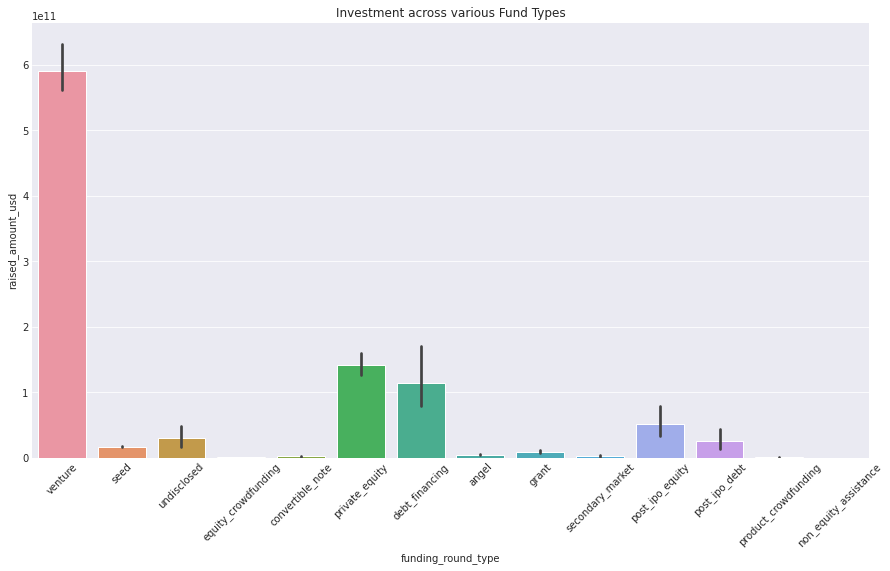

In [517]:
plt.figure(figsize = (15,8))
plt.title('Investment across various Fund Types')
sns.barplot(x='funding_round_type', y="raised_amount_usd", data=master_frame, estimator=np.sum)
plt.xticks(rotation=45)
plt.show()

Since, spark funding is only interested in these 4 types (seed, angel, venture, spark equity), we will filter the rest

In [518]:
master_frame=master_frame[master_frame.funding_round_type.isin(['seed','angel','venture','private_equity'])]
master_frame.shape

(94390, 16)

In [519]:
# Check for no of null values for the raisedamount_usd
master_frame.raised_amount_usd.isnull().sum()

13764

In [520]:
# lets see the same in percentage of entire data size
master_frame.raised_amount_usd.isnull().sum()/master_frame.shape[0]

0.14582053183599958

In [521]:
# Since, it constitutes 14.6 percentage of data. Imputing this column, we might end up with wrong analysis.
master_frame.dropna(subset=["raised_amount_usd"], inplace=True)
master_frame.shape

(80626, 16)

In [522]:
master_frame.raised_amount_usd.describe()

count    8.062600e+04
mean     9.348091e+06
std      7.562986e+07
min      0.000000e+00
25%      4.000000e+05
50%      2.000000e+06
75%      7.976016e+06
max      1.760000e+10
Name: raised_amount_usd, dtype: float64

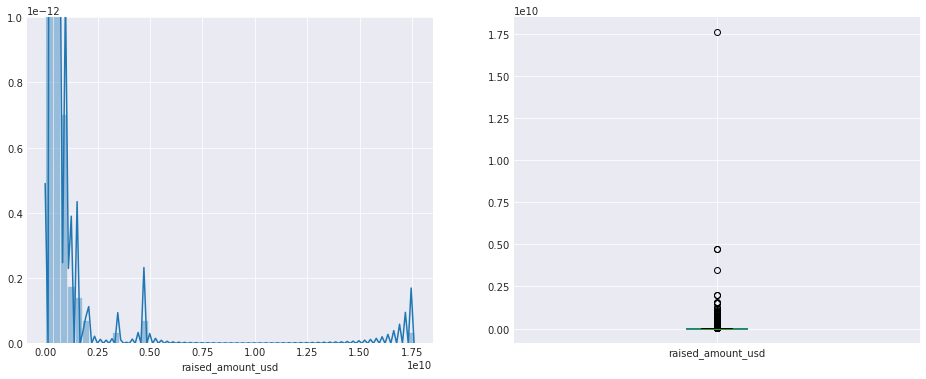

In [523]:
plt.figure(1)
plt.subplot(121)
sns.distplot(master_frame['raised_amount_usd']);

plt.subplot(122)
master_frame['raised_amount_usd'].plot.box(figsize=(16,6))

plt.show()

In [524]:
for funding_type in ['seed','angel','venture','private_equity']:
    print('Funding Type:', funding_type)
    print("Mean:", master_frame[master_frame.funding_round_type==funding_type]['raised_amount_usd'].mean())
    print("Median:", master_frame[master_frame.funding_round_type==funding_type]['raised_amount_usd'].median(),"\n")

Funding Type: seed
Mean: 719779.6202016778
Median: 275000.0 

Funding Type: angel
Mean: 958694.4697530865
Median: 400000.0 

Funding Type: venture
Mean: 11748949.129489528
Median: 5000000.0 

Funding Type: private_equity
Mean: 73308593.02944215
Median: 20000000.0 



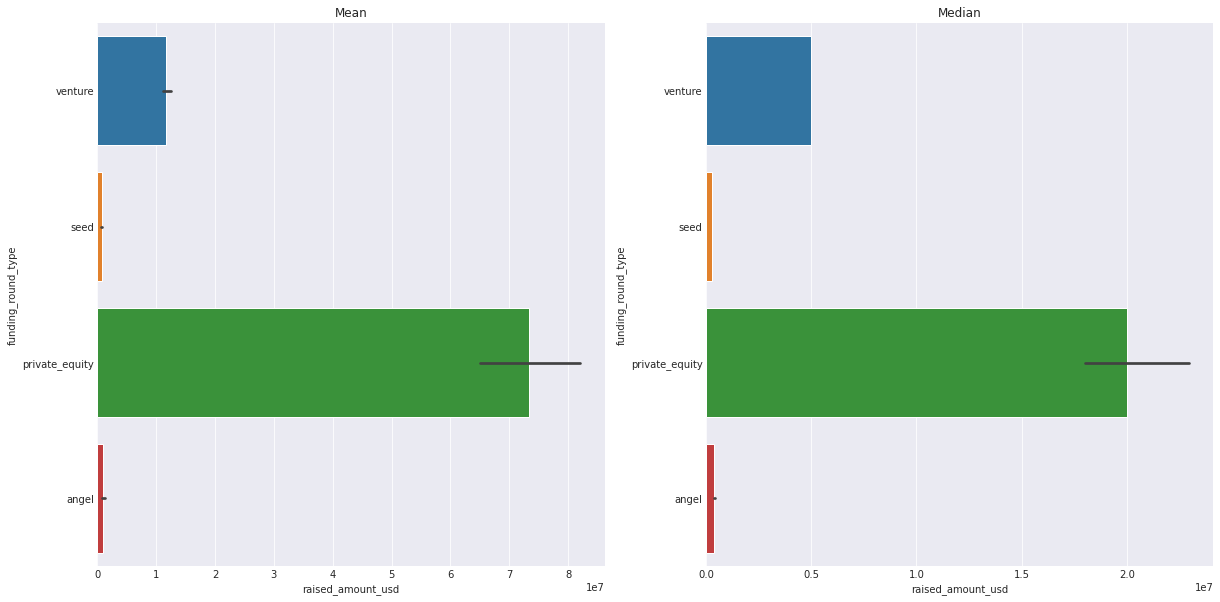

In [525]:
f,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Mean')
sns.barplot(x='raised_amount_usd', y="funding_round_type", data=master_frame, estimator=np.mean)
plt.subplot(1, 2, 2)
plt.title('Median')
sns.barplot(x='raised_amount_usd', y="funding_round_type", data=master_frame, estimator=np.median)
plt.show()

<b>By all statistics measure we can see, venture is the right funding type</b>

### Checkpoint 3: Country Analysis

Spark Funds wants to invest in countries with the highest amount of funding for the chosen investment type. This is a part of its broader strategy to invest where most investments are occurring.

In [526]:
master_frame=master_frame[master_frame.funding_round_type=='venture']
master_frame.shape

(50228, 16)

top 9 countries where most funds are received

In [527]:
top9 = master_frame.groupby("country_code")['raised_amount_usd'].sum().sort_values(ascending = False).reset_index().head(9)
top9

,country_code,raised_amount_usd
0,USA,4.225108e+11
1,CHN,3.983542e+10
2,GBR,2.024563e+10
3,IND,1.439186e+10
4,CAN,9.583332e+09
5,FRA,7.259537e+09
6,ISR,6.907515e+09
7,DEU,6.346960e+09
8,JPN,3.363677e+09


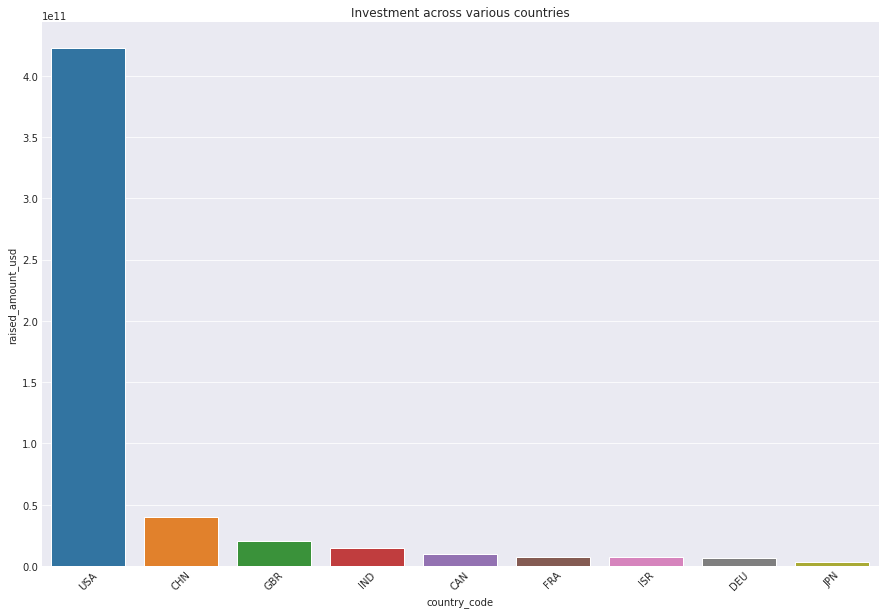

In [528]:
plt.figure(figsize = (15,10))
plt.title('Investment across various countries')
sns.barplot(x='country_code', y="raised_amount_usd", data=top9, estimator=np.sum)
plt.xticks(rotation=45)
plt.show()

<b>Amoung the top 9 countries, we can consider USA, GBR, IND as English speaking countries based on there english adaptation to the daily work life. Also as per wikipedia offical english speaking countries list.</b>

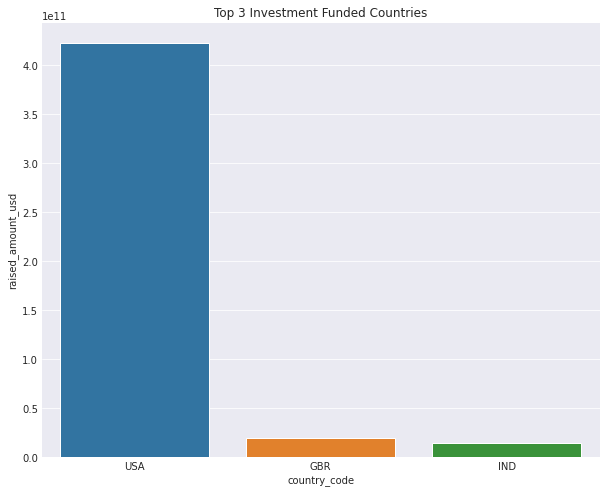

In [529]:
plt.figure(figsize = (10,8))
plt.title('Top 3 Investment Funded Countries')
sns.barplot(x='country_code', y="raised_amount_usd", data=top9[top9.country_code.isin(['USA','GBR','IND'])], estimator=np.sum)
plt.show()

### Checkpoint 4: Sector Analysis 1

Extract the primary sector of each category list from the category_list column

In [530]:
master_frame.dropna(subset=["category_list"], inplace=True)
master_frame.reset_index(inplace=True, drop=True)
master_frame.shape

(49726, 16)

In [531]:
master_frame['primary_sector']=master_frame.category_list.apply(lambda x: x.split('|')[0].lower() if '|' in x else x.lower())

In [532]:
mapping.dropna(inplace=True)
mapping=mapping.melt(id_vars="category_list",var_name="main_sector")
mapping=mapping[~(mapping["value"]==0)]
mapping=mapping[~(mapping['main_sector']=='Blanks')]
mapping['category']=mapping['category_list'].apply(lambda x: x.lower())
mapping.drop(['value','category_list'],inplace=True, axis=1)
mapping.reset_index(inplace=True, drop=True)
mapping.shape

(687, 2)

In [533]:
set3 = set(master_frame['primary_sector'].values)
set4 = set(mapping['category'].values)
sector_common = set3.intersection(set4)
sector_uncommon = set3.symmetric_difference(set4)

In [534]:
len(sector_common), len(sector_uncommon)

(549, 196)

In [535]:
sector_df=pd.merge(master_frame,mapping,how='inner',left_on='primary_sector',right_on='category')
sector_df.shape

(46523, 19)

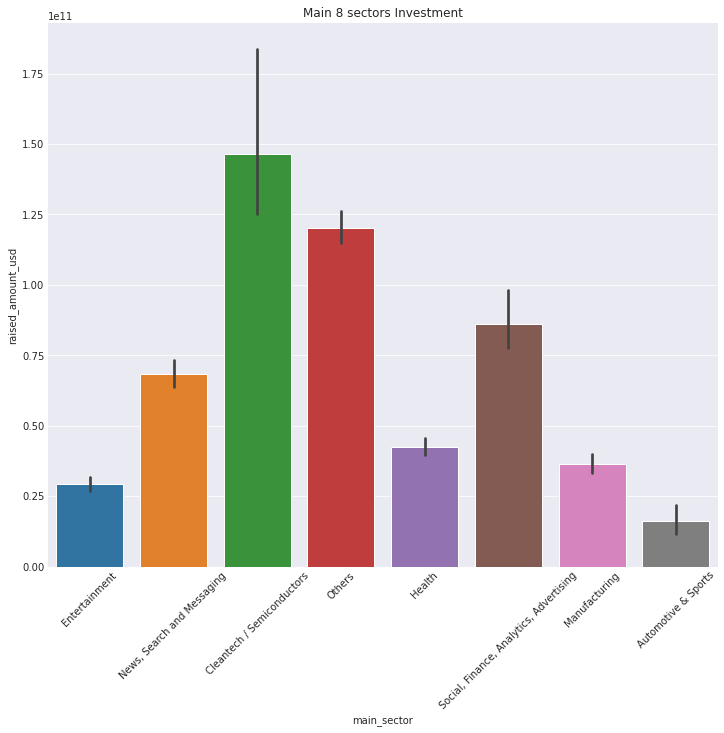

In [536]:
plt.figure(figsize = (12,10))
plt.title('Main 8 sectors Investment')
sns.barplot(x='main_sector', y="raised_amount_usd", data=sector_df, estimator=np.sum)
plt.xticks(rotation=45)
plt.show()

In [537]:
sector_df.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,primary_sector,main_sector,category
0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,media,Entertainment,media
1,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,06-10-2015,15000000.0,media,Entertainment,media
2,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,07-05-2013,5800000.0,media,Entertainment,media
3,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,operating,GBR,H9,London,London,01-01-2011,/organization/90min,/funding-round/fd4b15e8c97ee2ffc0acccdbe1a98810,venture,NaN,26-03-2014,18000000.0,media,Entertainment,media
4,/organization/all-def-digital,All Def Digital,http://alldefdigital.com,Media,operating,USA,CA,Los Angeles,Los Angeles,NaN,/organization/all-def-digital,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,A,06-08-2014,5000000.0,media,Entertainment,media


### Checkpoint 5: Sector Analysis 2

In [538]:
eight_sectors= ['Automotive & Sports', 'Cleantech / Semiconductors', 'Entertainment', 
                'Health', 'Manufacturing', 'News, Search and Messaging', 'Others',
               'Social, Finance, Analytics, Advertising'] 

In [539]:
usa_df=sector_df.loc[(sector_df['country_code']=='USA') & (sector_df['raised_amount_usd']>=5000000) & (sector_df['raised_amount_usd']<=15000000) & (sector_df['main_sector'].isin(eight_sectors))].reset_index(drop=True)
gbr_df=sector_df.loc[(sector_df['country_code']=='GBR') & (sector_df['raised_amount_usd']>=5000000) & (sector_df['raised_amount_usd']<=15000000) & (sector_df['main_sector'].isin(eight_sectors))].reset_index(drop=True)
ind_df=sector_df.loc[(sector_df['country_code']=='IND') & (sector_df['raised_amount_usd']>=5000000) & (sector_df['raised_amount_usd']<=15000000) & (sector_df['main_sector'].isin(eight_sectors))].reset_index(drop=True)

<b> USA Analysis</b>

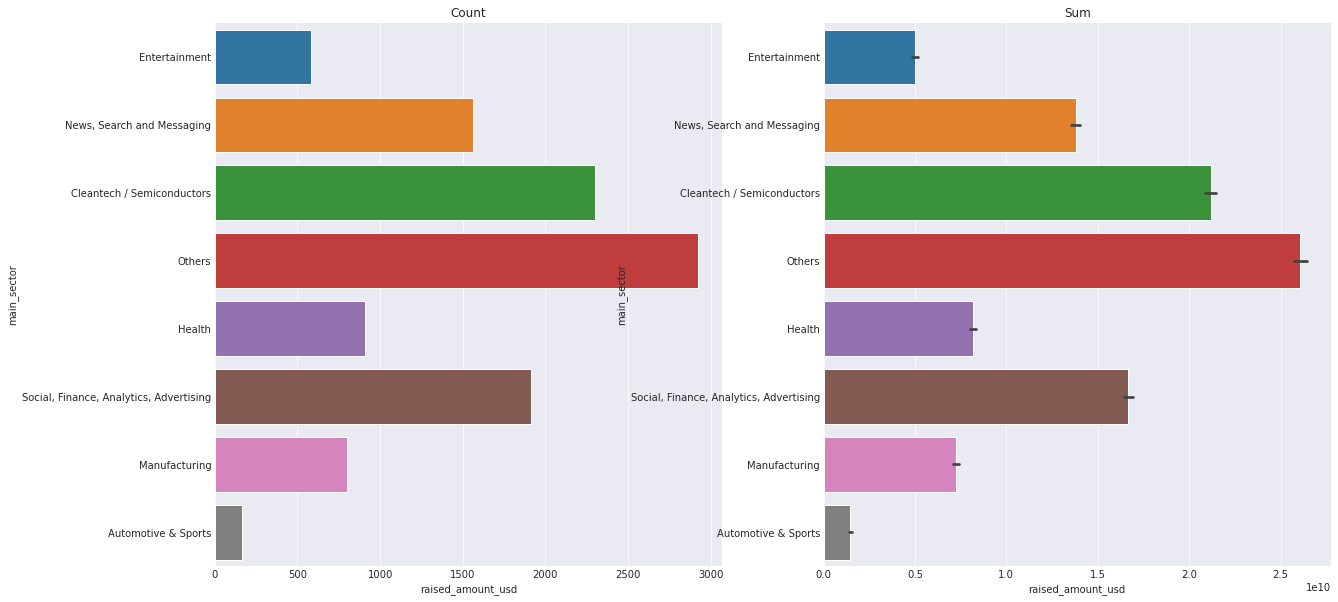

In [540]:
f,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Count')
sns.barplot(x='raised_amount_usd', y="main_sector", data=usa_df, estimator=len)
plt.subplot(1, 2, 2)
plt.title('Sum')
sns.barplot(x='raised_amount_usd', y="main_sector", data=usa_df, estimator=np.sum)
plt.show()

In [541]:
usa_df.main_sector.value_counts().sum()

11149

In [542]:
usa_df.raised_amount_usd.sum()

99661524549.0

In [543]:
pd.DataFrame(usa_df.main_sector.value_counts())

,main_sector
Others,2923
Cleantech / Semiconductors,2297
"Social, Finance, Analytics, Advertising",1912
"News, Search and Messaging",1563
Health,908
Manufacturing,799
Entertainment,580
Automotive & Sports,167


In [544]:
usa_df[usa_df['main_sector']=='Others'].groupby(by='company_permalink')['raised_amount_usd'].sum().sort_values(ascending = False).head(5)

company_permalink
/organization/virtustream            64300000.0
/organization/capella                54968051.0
/organization/airtight-networks      54201907.0
/organization/decarta                52100000.0
/organization/black-duck-software    51000000.0
Name: raised_amount_usd, dtype: float64

<b>GBR Analysis</b>

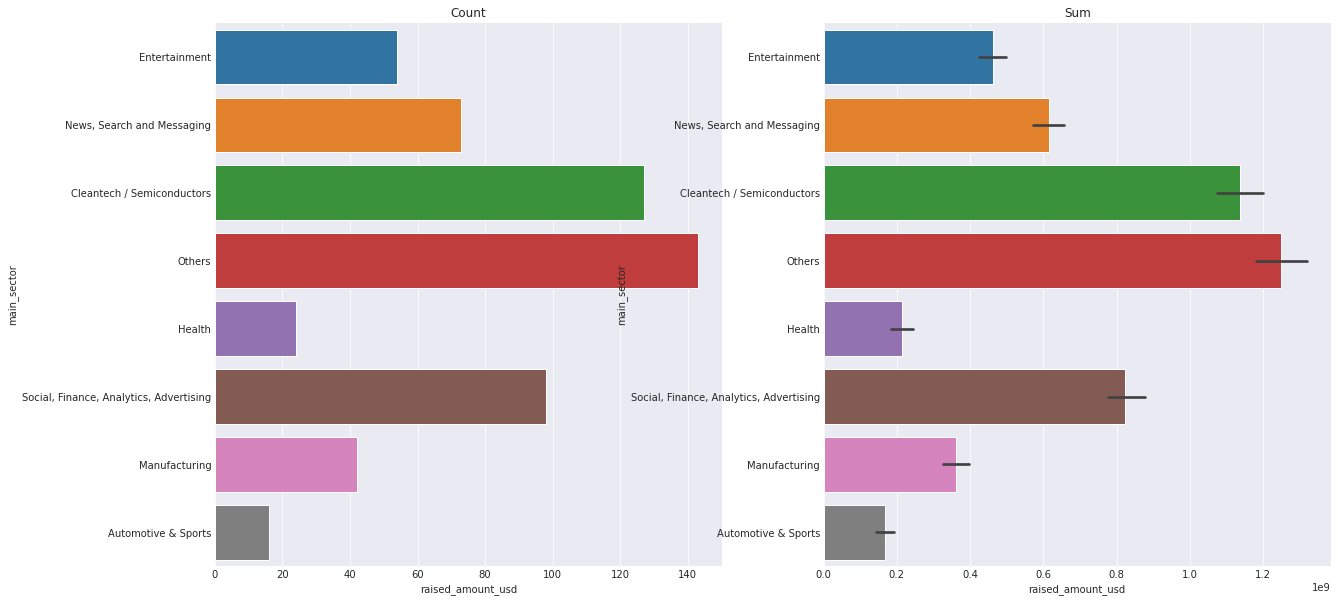

In [545]:
f,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Count')
sns.barplot(x='raised_amount_usd', y="main_sector", data=gbr_df, estimator=len)
plt.subplot(1, 2, 2)
plt.title('Sum')
sns.barplot(x='raised_amount_usd', y="main_sector", data=gbr_df, estimator=np.sum)
plt.show()

In [546]:
gbr_df.main_sector.value_counts().sum()

577

In [547]:
gbr_df.raised_amount_usd.sum()

5028704358.0

In [548]:
pd.DataFrame(gbr_df.main_sector.value_counts())

,main_sector
Others,143
Cleantech / Semiconductors,127
"Social, Finance, Analytics, Advertising",98
"News, Search and Messaging",73
Entertainment,54
Manufacturing,42
Health,24
Automotive & Sports,16


In [549]:
gbr_df[gbr_df['main_sector']=='Others'].groupby(by='company_permalink')['raised_amount_usd'].sum().sort_values(ascending = False).head(5)

company_permalink
/organization/electric-cloud             37000000.0
/organization/sensage                    36250000.0
/organization/enigmatic                  32500000.0
/organization/silverrail-technologies    29000000.0
/organization/opencloud                  27972766.0
Name: raised_amount_usd, dtype: float64

<b>IND Analysis</b>

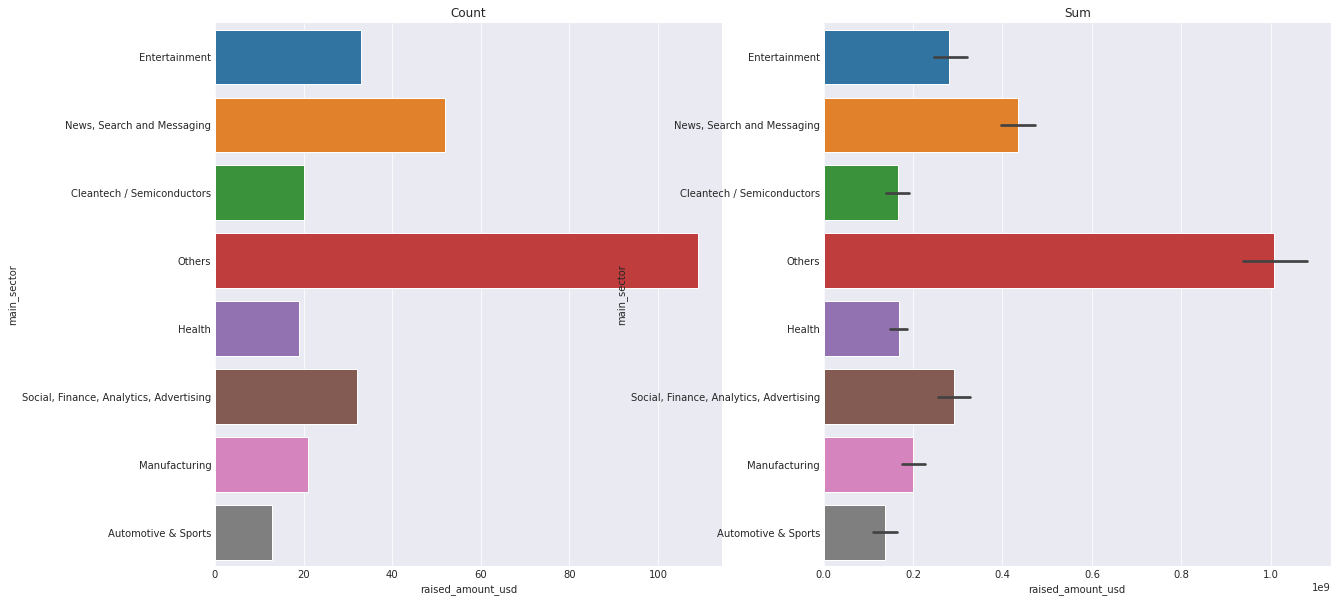

In [550]:
f,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Count')
sns.barplot(x='raised_amount_usd', y="main_sector", data=ind_df, estimator=len)
plt.subplot(1, 2, 2)
plt.title('Sum')
sns.barplot(x='raised_amount_usd', y="main_sector", data=ind_df, estimator=np.sum)
plt.show()

In [551]:
ind_df.main_sector.value_counts().sum()

299

In [552]:
ind_df.raised_amount_usd.sum()

2683537552.0

In [553]:
pd.DataFrame(ind_df.main_sector.value_counts())

,main_sector
Others,109
"News, Search and Messaging",52
Entertainment,33
"Social, Finance, Analytics, Advertising",32
Manufacturing,21
Cleantech / Semiconductors,20
Health,19
Automotive & Sports,13


In [554]:
ind_df[ind_df['main_sector']=='Others'].groupby(by='company_permalink')['raised_amount_usd'].sum().sort_values(ascending = False).head(5)

company_permalink
/organization/firstcry-com        39000000.0
/organization/myntra              38000000.0
/organization/commonfloor         32900000.0
/organization/pepperfry-com       28000000.0
/organization/itzcash-card-ltd    25000000.0
Name: raised_amount_usd, dtype: float64

### checkpoint 6: Three plots

A plot showing the representative amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.   

A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.                                                                                                                                                                             

A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). This plot should clearly display the top 3 sectors each in Country 1, Country 2, and Country 3.

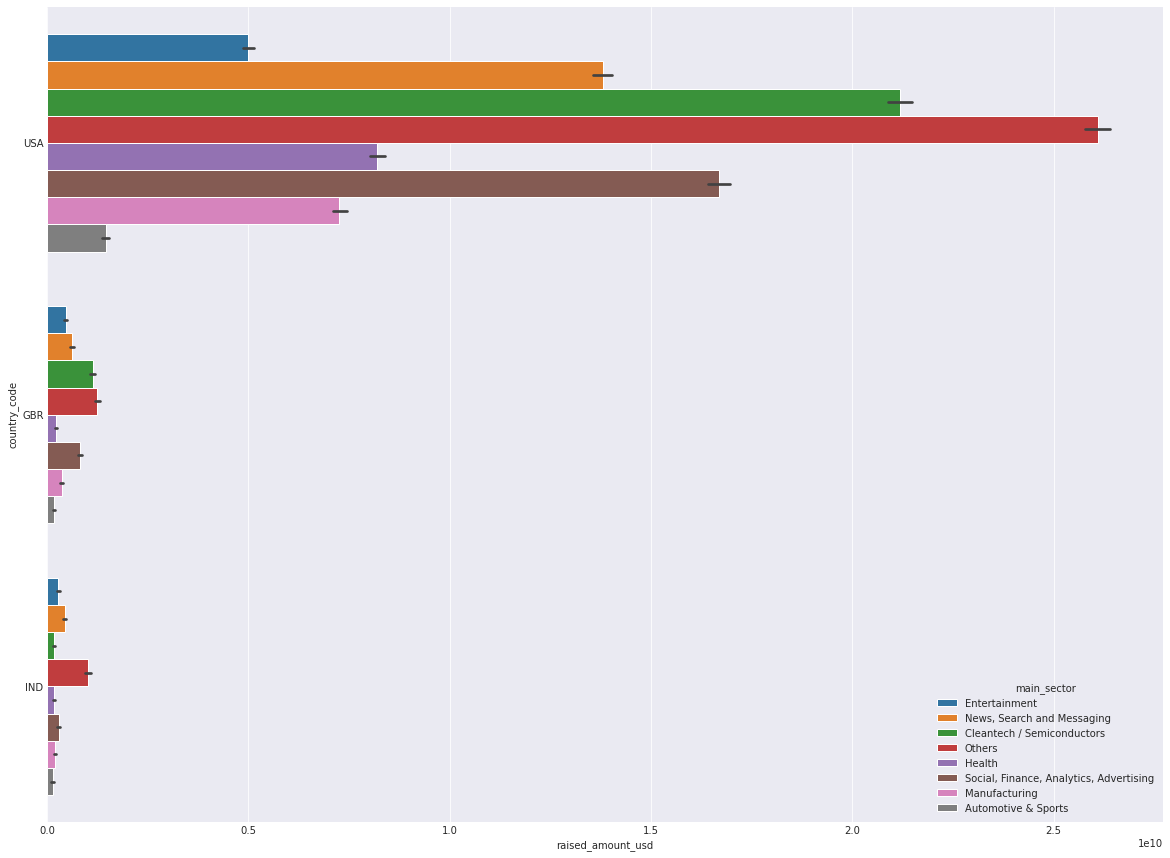

In [555]:
top3 = pd.concat([usa_df, gbr_df, ind_df])
plt.figure(figsize=(20, 15))
sns.barplot(y='country_code', x='raised_amount_usd', hue="main_sector", data=top3, estimator=np.sum)
plt.show()